In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
from sklearn.metrics import confusion_matrix, classification_report

from keras.optimizers import Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

##############################################
learning_rate = 0.1  # initial learning rate
min_learning_rate = 0.00001  # once the learning rate reaches this value, do not decrease it further
learning_rate_reduction_factor = 0.5  # the factor used when reducing the learning rate -> learning_rate *= learning_rate_reduction_factor
patience = 3  # how many epochs to wait before reducing the learning rate when the loss plateaus
verbose = 1  # controls the amount of logging done during training and testing: 0 - none, 1 - reports metrics after each batch, 2 - reports metrics after each epoch
image_size = (100, 100)  # width and height of the used images
input_shape = (100, 100, 3)  # the expected input shape for the trained models; since the images in the Fruit-360 are 100 x 100 RGB images, this is the required input shape

use_label_file = False  # set this to true if you want load the label names from a file; uses the label_file defined below; the file should contain the names of the used labels, each label on a separate line
label_file = 'labels.txt'
base_dir = '../fruits-360_dataset/fruits-360/'  # relative path to the Fruit-Images-Dataset folder
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')
output_dir = 'output_files'  # root folder in which to save the the output files; the files will be under output_files/model_name 
##############################################

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.strip() for x in f.readlines()]
else:
    labels = os.listdir(train_dir)
num_classes = len(labels)


# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(40, 40))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cbar_kws={"shrink": 0.8})
    if out_path:
        plt.savefig(out_path + "/confusion_matrix.png")  # as in the plot_model_history, the matrix is saved in a file called "model_name_confusion_matrix.png"
    return ax


# given the train and test folder paths and a validation to test ratio, this method creates three generators
#  - the training generator uses (100 - validation_percent) of images from the train set 
#    it applies random horizontal and vertical flips for data augmentation and generates batches randomly
#  - the validation generator uses the remaining validation_percent of images from the train set
#    does not generate random batches, as the model is not trained on this data
#    the accuracy and loss are monitored using the validation data so that the learning rate can be updated if the model hits a local optimum
#  - the test generator uses the test set without any form of augmentation
#    once the training process is done, the final values of accuracy and loss are calculated on this set

def build_data_generators(train_folder, test_folder, validation_percent, labels=None, image_size=(100, 100), batch_size=50):
    train_datagen = ImageDataGenerator(
        width_shift_range=0.0,
        height_shift_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,  # randomly flip images
        validation_split=validation_percent)  # percentage indicating how much of the training set should be kept for validation

    test_datagen = ImageDataGenerator()

    train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=True, subset='training', classes=labels)
    validation_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                       batch_size=batch_size, shuffle=False, subset='validation', classes=labels)
    test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                                batch_size=batch_size, shuffle=False, subset=None, classes=labels)
    return train_gen, validation_gen, test_gen


# this method performs all the steps from data setup, training and testing the model and plotting the results
# the model is any trainable model; the input shape and output number of classes is dependant on the dataset used, in this case the input is 100x100 RGB images and the output is a softmax layer with 118 probabilities
# the name is used to save the classification report containing the f1 score of the model, the plots showing the loss and accuracy and the confusion matrix
# the batch size is used to determine the number of images passed through the network at once, the number of steps per epochs is derived from this as (total number of images in set // batch size) + 1
def train_and_evaluate_model(model, name="", epochs=10, batch_size=50, verbose=verbose, useCkpt=False):
    print(model.summary())
    model_out_dir = os.path.join(output_dir, name)
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)
    if useCkpt:
        model.load_weights(model_out_dir + "/model.h5")

    trainGen, validationGen, testGen = build_data_generators(train_dir, test_dir, validation_percent=0.1, labels=labels, image_size=image_size, batch_size=batch_size)
    optimizer = Adadelta(lr=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose, 
                                                factor=learning_rate_reduction_factor, min_lr=min_learning_rate)
    save_model = ModelCheckpoint(filepath=model_out_dir + "/model.h5", monitor='val_acc', verbose=verbose, 
                                 save_best_only=True, save_weights_only=False, mode='max', period=1)
    
    history = model.fit_generator(generator=trainGen,
                                  epochs=epochs,
                                  steps_per_epoch=(trainGen.n // batch_size) + 1,
                                  validation_data=validationGen,
                                  validation_steps=(validationGen.n // batch_size) + 1,
                                  verbose=verbose,
                                  callbacks=[learning_rate_reduction, save_model])

    validationGen.reset()
    loss_v, accuracy_v = model.evaluate_generator(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)
    loss, accuracy = model.evaluate_generator(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))
    testGen.reset()
    y_pred = model.predict_generator(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    y_true = testGen.classes[testGen.index_array]
    plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, out_path=model_out_dir)
    class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)
    model.save('my_model_01.hdf5')
    with open(model_out_dir + "/classification_report.txt", "w") as text_file:
        text_file.write("%s" % class_report)
    # print(class_report)


print(labels)
print(num_classes)

['Banana', 'Nectarine', 'Tomato 3', 'Pear', 'Potato Red Washed', 'Pear Abate', 'Physalis with Husk', 'Mango', 'Grape White 3', 'Pitahaya Red', 'Pepper Red', 'Onion Red Peeled', 'Grapefruit White', 'Cactus fruit', 'Strawberry', 'Cherry 2', 'Mango Red', 'Tamarillo', 'Apple Red 1', 'Apple Golden 3', 'Grape Pink', 'Pineapple Mini', 'Pineapple', 'Cherry 1', 'Plum', 'Grape White', 'Quince', 'Nut Forest', 'Grape White 2', 'Tomato Maroon', 'Kohlrabi', 'Limes', 'Peach 2', 'Lychee', 'Plum 2', 'Lemon', 'Redcurrant', 'Beetroot', 'Apple Golden 1', 'Cherry Wax Yellow', 'Peach', 'Guava', 'Tomato Cherry Red', 'Carambula', 'Chestnut', 'Ginger Root', 'Orange', 'Nectarine Flat', 'Avocado', 'Banana Red', 'Pepper Yellow', 'Cauliflower', 'Huckleberry', 'Strawberry Wedge', 'Pear Williams', 'Physalis', 'Salak', 'Cantaloupe 2', 'Hazelnut', 'Potato White', 'Rambutan', 'Mandarine', 'Blueberry', 'Apricot', 'Eggplant', 'Cantaloupe 1', 'Lemon Meyer', 'Tomato 2', 'Apple Pink Lady', 'Mulberry', 'Peach Flat', 'Pepper 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 100, 100, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 100, 100, 4)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1616      
_________________________________________________________________
conv1_relu (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 50, 50, 32)        12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 50, 50, 32)        0   

/home/jushaan/Downloads/yes/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1090/1090 [==============================] - 802s 735ms/step - loss: 1.3166 - accuracy: 0.6472 - val_loss: 0.0015 - val_accuracy: 0.9176
Epoch 3/10
1090/1090 [==============================] - 815s 747ms/step - loss: 0.3368 - accuracy: 0.8978 - val_loss: 4.0173e-06 - val_accuracy: 0.9595
Epoch 4/10
1090/1090 [==============================] - 814s 747ms/step - loss: 0.1614 - accuracy: 0.9500 - val_loss: 3.0398e-07 - val_accuracy: 0.9731
Epoch 5/10
1090/1090 [==============================] - 813s 746ms/step - loss: 0.1035 - accuracy: 0.9674 - val_loss: 7.1525e-07 - val_accuracy: 0.9736
Epoch 6/10
1090/1090 [==============================] - 795s 730ms/step - loss: 0.0727 - accuracy: 0.9769 - val_loss: 5.1856e-07 - val_accuracy: 0.9784

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
Epoch 7/10
1090/1090 [==============================] - 809s 742ms/step - loss: 0.0310 - accuracy: 0.9903 - val_loss: 0.0000e+00 - val_accuracy: 0.9837
Epoch 8/10
1090/1090 [==

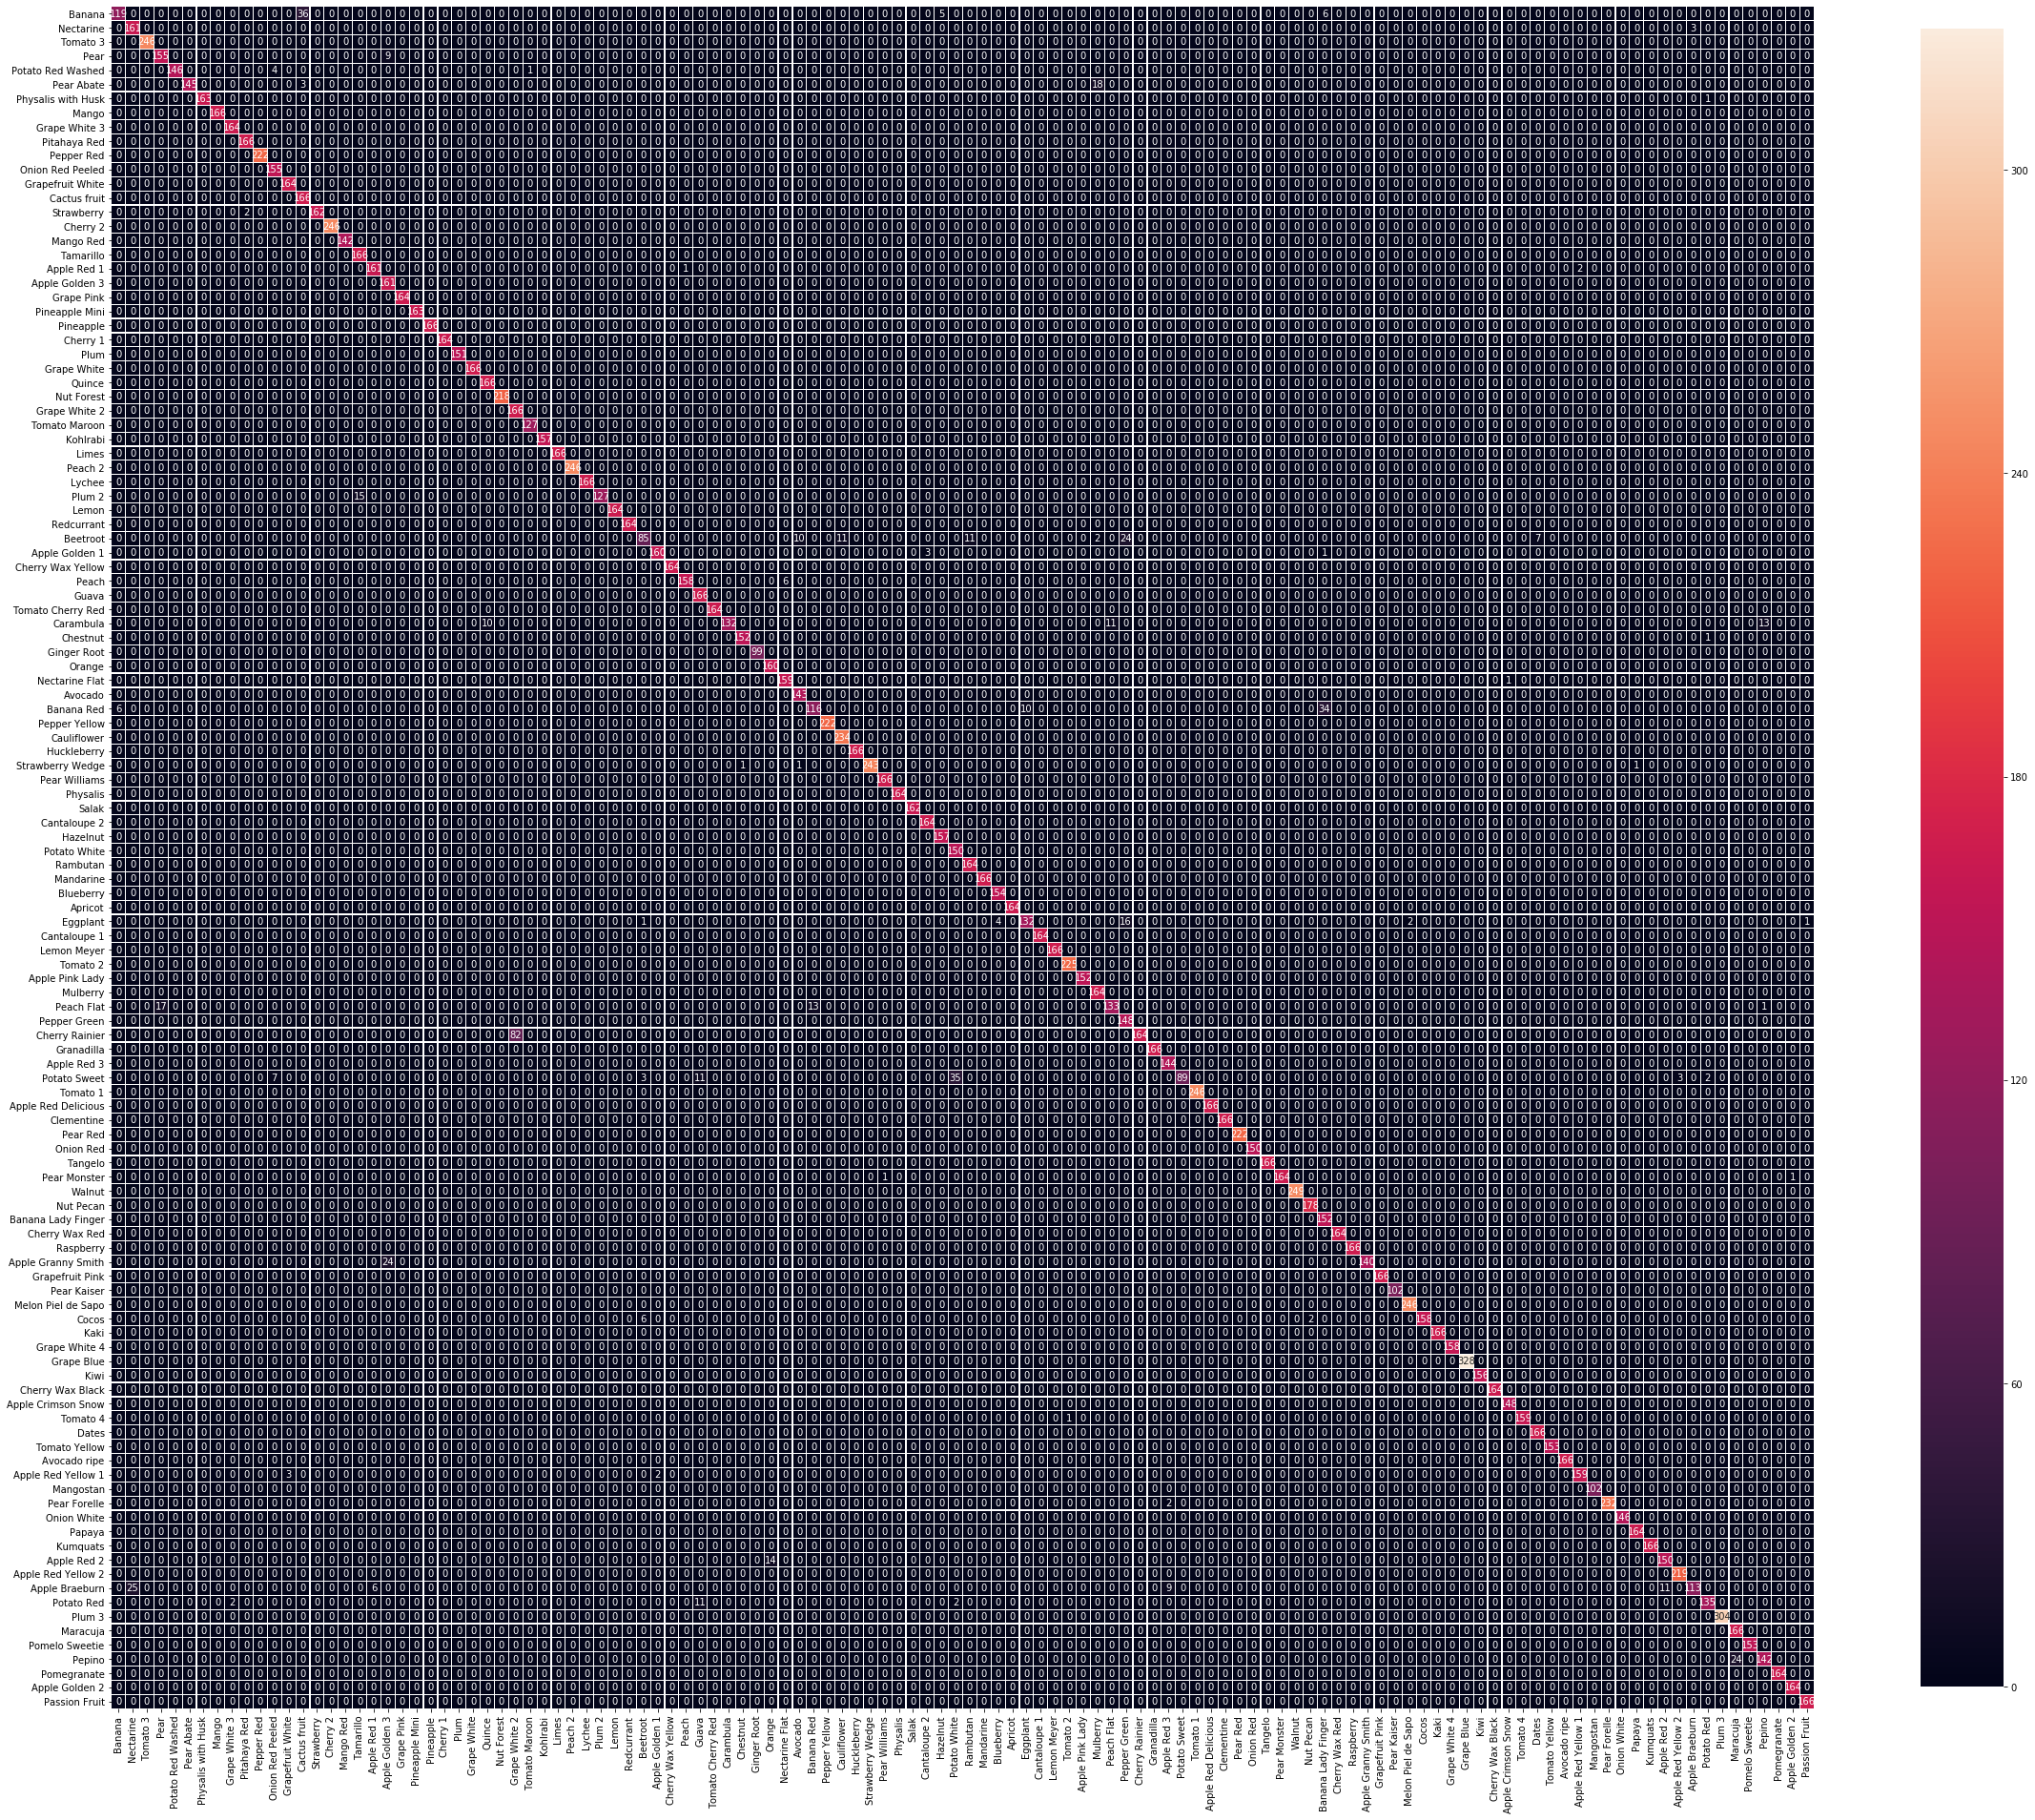

In [2]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda
from keras.models import model_from_json

# Create a custom layer that converts the original image from 
# RGB to HSV and grayscale and concatenates the results
# forming in input of size 100 x 100 x 4 
def image_process(x):
    import tensorflow as tf
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    rez = tf.concat([hsv, gray], axis=-1)
    return rez


def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(image_process)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez


model = network(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="fruit-360 model")

In [4]:
?python